# MixFlows with discretized Hamiltonian dynamics

In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import sys, time
sys.path.insert(1, '../discrete_mixflows/')
from discrete_mixflows import *
from aux import LogSumExp

plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams["figure.figsize"]=15,7.5
plt.rcParams.update({'font.size': 24})

In [176]:
def lqN(x,rho,u,N,lq0,L,epsilon,grad_lp,xi=np.pi/16):
    x_,rho_,u_=np.copy(x),np.copy(rho),np.copy(u)
    lm,Fm,Qm,grad_lm=lap_lm,lap_Fm,lap_Qm,lap_gradlm # laplacian momentum
    if N==0: return lq0(x_,rho_,u_)
    w=np.zeros((N,x_.shape[1]))
    w[0,:]=lq0(x_,rho_,u_)
    lJ=np.zeros(x_.shape[1])
    
    ########################################
    # CACHEING FOR DEBUGGING
    ########################################
    xs=np.zeros((N,x.shape[0],x.shape[1]))
    xs[0,:,:]=x_
    rhos=np.zeros((N,rho.shape[0],rho.shape[1]))
    rhos[0,:,:]=rho_
    us=np.zeros((N,u.shape[0]))
    us[0,:]=u_
    
    print('Flow: 0')
    print('x: '+str(x_[0,0]))
    print('rho: '+str(rho_[0,0]))
    print('Gaussian weight: '+str(np.exp(gauss_lp(x_,mu0,sigma0)[0])))
    print('Laplace weight: '+str(np.exp(lap_lm(rho_)[0])))
    print('weight: '+str(np.exp(w[0,0])))
    print()
    ########################################
    ########################################
    
    for n in range(N-1):
        print('Flow: '+str(n+1))
        x_,rho_,u_,tlJ,_,_,_=flow(1,x_,rho_,u_,L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi,'bwd')
        lJ=lJ+tlJ
        print('x: '+str(x_[0,0]))
        print('rho: '+str(rho_[0,0]))
        print('J: '+str(np.exp(tlJ[0])))
        print('total J: '+str(np.sum(np.exp(lJ[0]))))
        w[n+1,:]=lq0(x_,rho_,u_)+tlJ
        print('Gaussian weight: '+str(np.exp(gauss_lp(x_,mu0,sigma0)[0])))
        print('Laplace weight: '+str(np.exp(lap_lm(rho_)[0])))
        print('weight: '+str(np.exp(w[n+1,0])))
        print('sum weights: '+str(np.sum(np.exp(w[:(n+2),0]))))
        print()
        
        ########################################
        # CACHEING FOR DEBUGGING
        ########################################
        xs[n+1,:,:]=x_
        rhos[n+1,:,:]=rho_
        us[n+1,:]=u_
        ########################################
        ########################################
    # end for
    return LogSumExp(w)-np.log(N),xs,rhos,us
    #return np.log(np.sum(np.exp(w),axis=0))-np.log(N),xs,rhos,us

def randqN(size,N,randq0,L,epsilon,grad_lp,xi=np.pi/16):
    if N==1: return randq0(size)
    K=np.random.randint(low=0,high=N,size=size)
    lm,Fm,Qm,grad_lm=lap_lm,lap_Fm,lap_Qm,lap_gradlm # laplacian momentum
    x,rho,u=randq0(size)
    for n in range(N):
        tx,trho,tu,_,_,_,_=flow(1,x[:,K>=n+1],rho[:,K>=n+1],u[K>=n+1],L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi,'fwd') # update those with large enough K
        x[:,K>=n+1]=tx
        rho[:,K>=n+1]=trho
        u[K>=n+1]=tu
    # end for
    return x,rho,u
    


def flow(steps,x,rho,u,L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi,direction):
    x_,rho_,u_=np.copy(x),np.copy(rho),np.copy(u)
    lJ=np.zeros(x_.shape[1])
    if steps==0: return x_,rho_,u_,lJ
    
    # CACHEING FOR DEBUGGING
    xs=np.zeros((steps+1,x.shape[0],x.shape[1]))
    xs[0,:,:]=x_
    rhos=np.zeros((steps+1,rho.shape[0],rho.shape[1]))
    rhos[0,:,:]=rho_
    us=np.zeros((steps+1,u.shape[0]))
    us[0,:]=u_
    ###
    for n in range(steps):
        #print(str(n+1)+'/'+str(steps),end='\r')
        if direction=='fwd': x_,rho_,u_,tmplJ=forward( x_,rho_,u_,L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi)
        if direction=='bwd': x_,rho_,u_,tmplJ=backward(x_,rho_,u_,L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi)
        lJ=lJ+tmplJ
        
        # CACHEING FOR DEBUGGING
        xs[n+1,:,:]=x_
        rhos[n+1,:,:]=rho_
        us[n+1,:]=u_
        ###
    # end for
    return x_,rho_,u_,lJ,xs,rhos,us

def forward(x,rho,u,L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi):
    x_,rho_=Ham(x,rho,L,epsilon,grad_lp,grad_lm)
    lJ=lm(rho_)
    u_=(u+xi)%1
    rho_=Qm((Fm(rho_)+pseudo_random(x_,u_))%1)
    lJ=lJ-lm(rho_)
    return x_,rho_,u_,lJ

def backward(x,rho,u,L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi):
    x_,rho_,u_=np.copy(x),np.copy(rho),np.copy(u)
    lJ=lm(rho_)
    rho_=Qm((Fm(rho_)-pseudo_random(x_,u_))%1)
    lJ=lJ-lm(rho_)
    u_=(1.+u_-xi)%1
    x_,rho_=Ham(x_,rho_,L,-epsilon,grad_lp,grad_lm)
    return x_,rho_,u_,lJ

def Ham(x,rho,L,epsilon,grad_lp,grad_lm):
    x_,rho_=np.copy(x),np.copy(rho)
    for l in range(L):
        rhot = rho_  + epsilon*grad_lp(x_)/2
        x_    = x_   - epsilon*grad_lm(rhot)
        rho_  = rhot + epsilon*grad_lp(x_)/2
    # end for
    return x_,rho_

def lap_lm(rho): return -np.sum(np.abs(rho),axis=0)-rho.shape[0]*np.log(2.) #(M,d)->(d,)
def lap_Fm(rho): return 0.5-0.5*np.sign(rho)*np.expm1(-np.abs(rho)) #(M,d)->(M,d)
def lap_Qm(p)  : return np.sign(0.5-p)*np.log1p(-2.*np.abs(p-0.5)) #(M,d)->(M,d)
def lap_gradlm(rho): return -np.sign(rho) #(M,d)->(M,d)

def gauss_lp(x,mu,sigma): return -0.5*np.sum((x-mu)**2,axis=0)/sigma**2-x.shape[0]*np.log(2*np.pi*sigma**2)/2
def pseudo_random(x,u): return 0.5*np.sin(2*x+u)+0.5

In [180]:
# target specification
def lp(x): return gauss_lp(x,0.,1.)
def grad_lp(x): return -x

# ref specification
mu0=2.
sigma0=0.3
def lq0(x,rho,u): return gauss_lp(x,mu0,sigma0)+lap_lm(rho)
def randq0(size): return mu0+sigma0*np.random.randn(1,size),np.random.laplace(size=(1,size)),np.random.rand(size)

ss=1000
q0_sample=mu0+sigma0*np.random.randn(1,ss)

## Forward pass

In [142]:
# settings
steps=20
ss=1000
x=mu0+sigma0*np.random.randn(1,ss)
rho=np.random.laplace(size=(1,ss))
u=np.random.rand(ss)
L=50
epsilon=0.1
lm,Fm,Qm,grad_lm=lap_lm,lap_Fm,lap_Qm,lap_gradlm
xi=np.pi/16

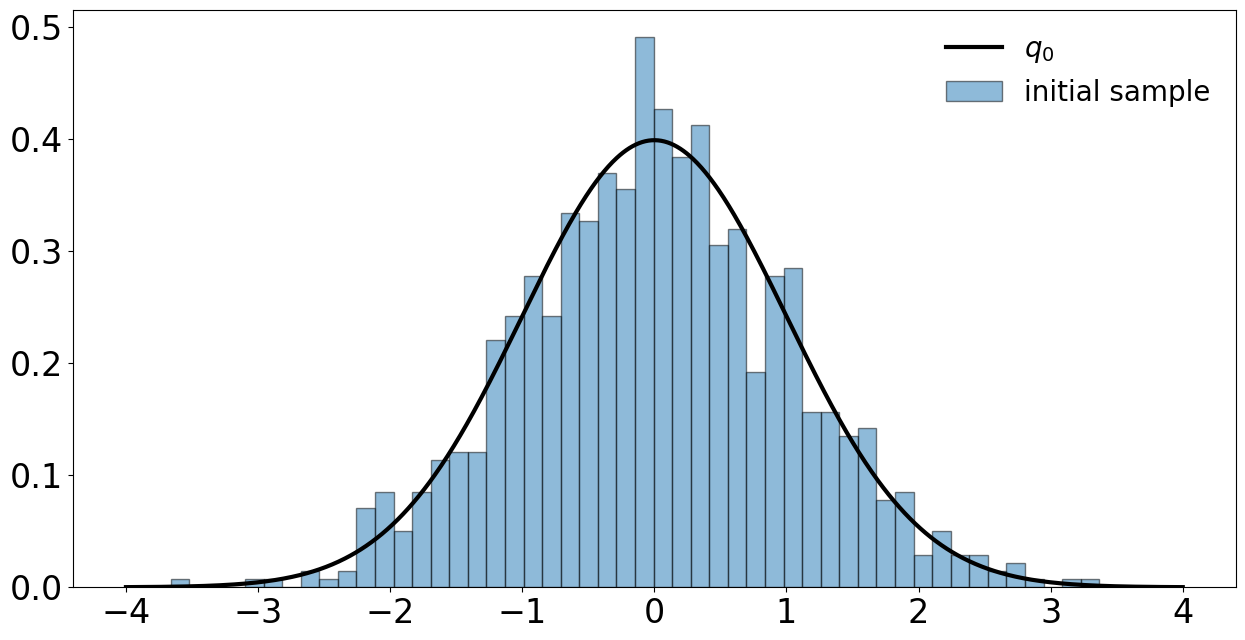

In [143]:
ttx=np.linspace(mu0-4*sigma0,mu0+4*sigma0,1000)
plt.plot(ttx,np.exp(gauss_lp(ttx[np.newaxis,:],mu0,sigma0)),c='black',lw=3,label=r'$q_0$')
plt.hist(x[0,:],alpha=0.5,density=True,bins=50,ec='black',label='initial sample');
plt.legend(fontsize='small',frameon=False)

In [144]:
xp,rhop,up,lJ,xs,rhos,us=flow(steps,x,rho,u,L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi,direction='fwd')

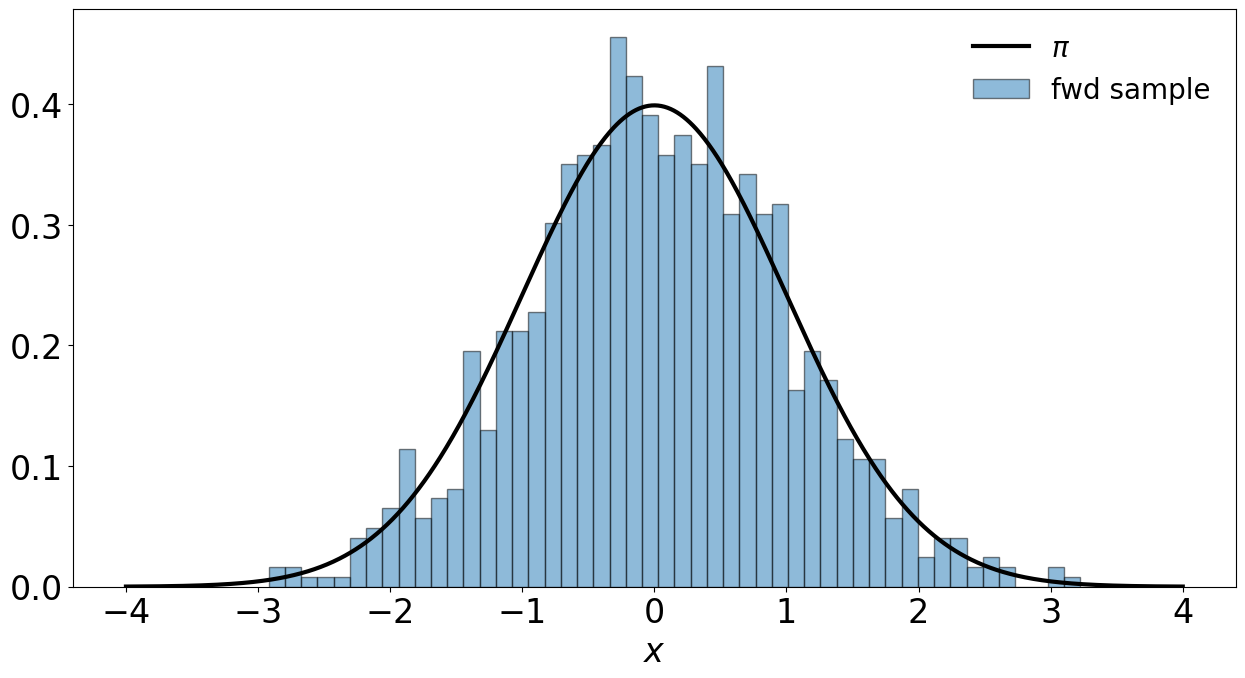

In [145]:
ttxp=np.linspace(-4,4,1000)
plt.plot(ttxp,np.exp(lp(ttxp[np.newaxis,:])),c='black',lw=3,label=r'$\pi$')
plt.hist(xp[0,:],alpha=0.5,density=True,bins=50,ec='black',label='fwd sample');
plt.xlabel(r'$x$')
plt.legend(fontsize='small',frameon=False)

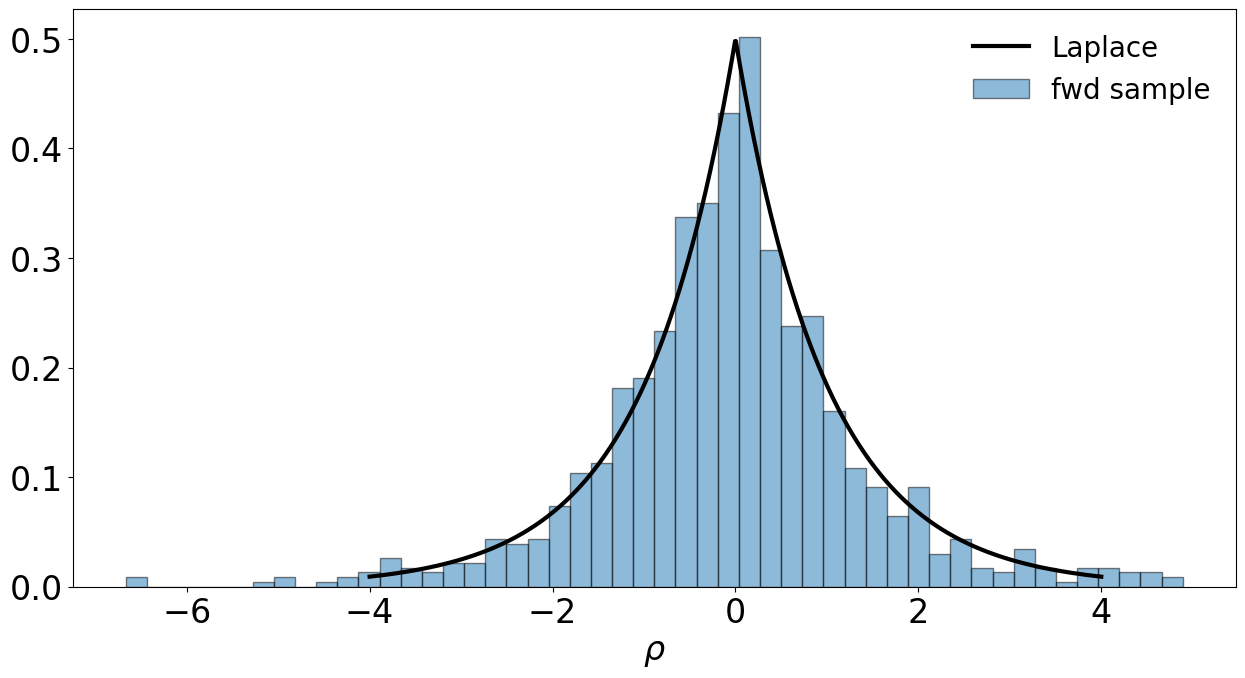

In [146]:
ttrho=np.linspace(-4,4,1000)
plt.plot(ttrho,np.exp(lap_lm(ttrho[np.newaxis,:])),c='black',lw=3,label='Laplace')
plt.hist(rhop[0,:],alpha=0.5,density=True,bins=50,ec='black',label='fwd sample');
plt.xlabel(r'$\rho$')
plt.legend(fontsize='small',frameon=False)

Text(0.5, 0, '$u$')

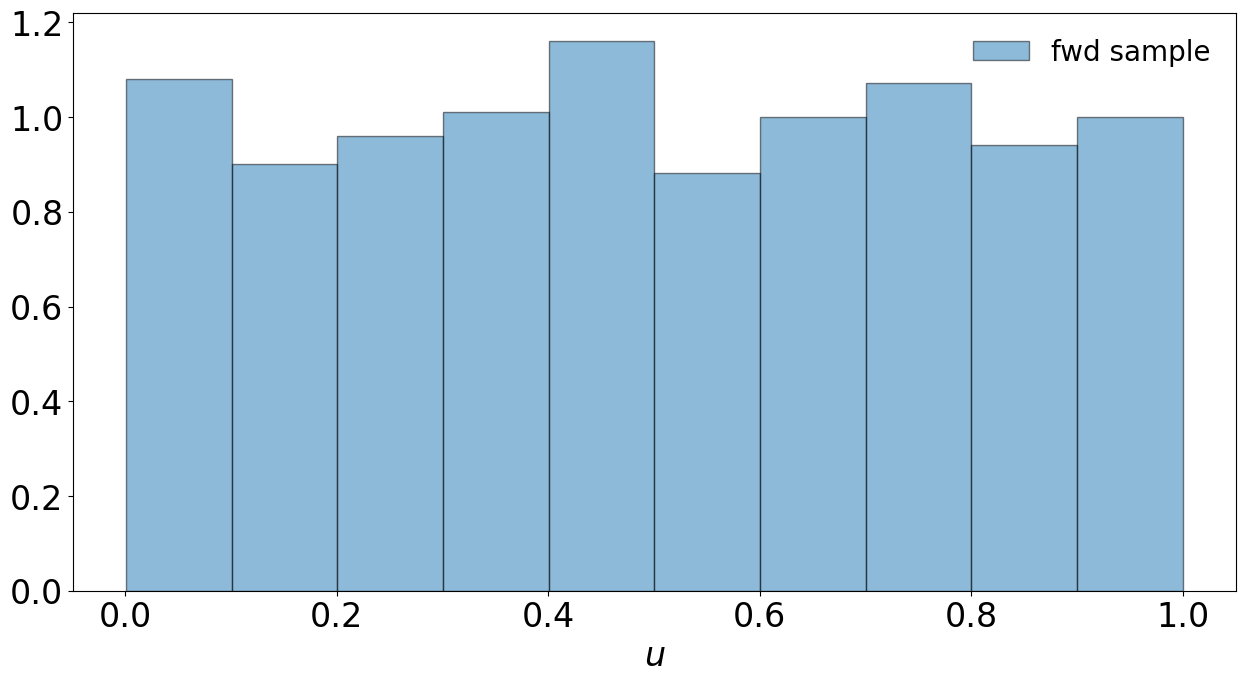

In [147]:
plt.hist(up,alpha=0.5,density=True,bins=10,ec='black',label='fwd sample');
plt.legend(fontsize='small',frameon=False)
plt.xlabel(r'$u$')

## Backward pass

In [148]:
xpp,rhopp,upp,lJ,xps,rhops,ups=flow(steps,xp,rhop,up,L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi,direction='bwd')

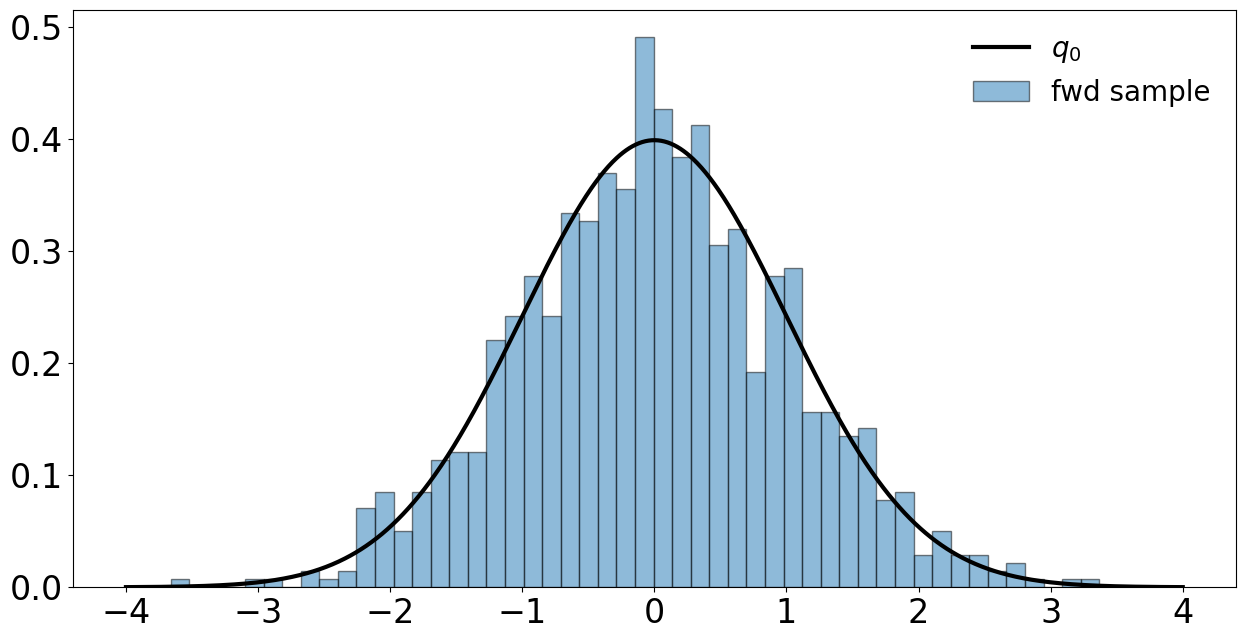

In [149]:
ttx=np.linspace(mu0-4*sigma0,mu0+4*sigma0,1000)
plt.plot(ttx,np.exp(gauss_lp(ttx[np.newaxis,:],mu0,sigma0)),c='black',lw=3,label=r'$q_0$')
plt.hist(xpp[0,:],alpha=0.5,density=True,bins=50,ec='black',label='fwd sample');
plt.legend(fontsize='small',frameon=False)

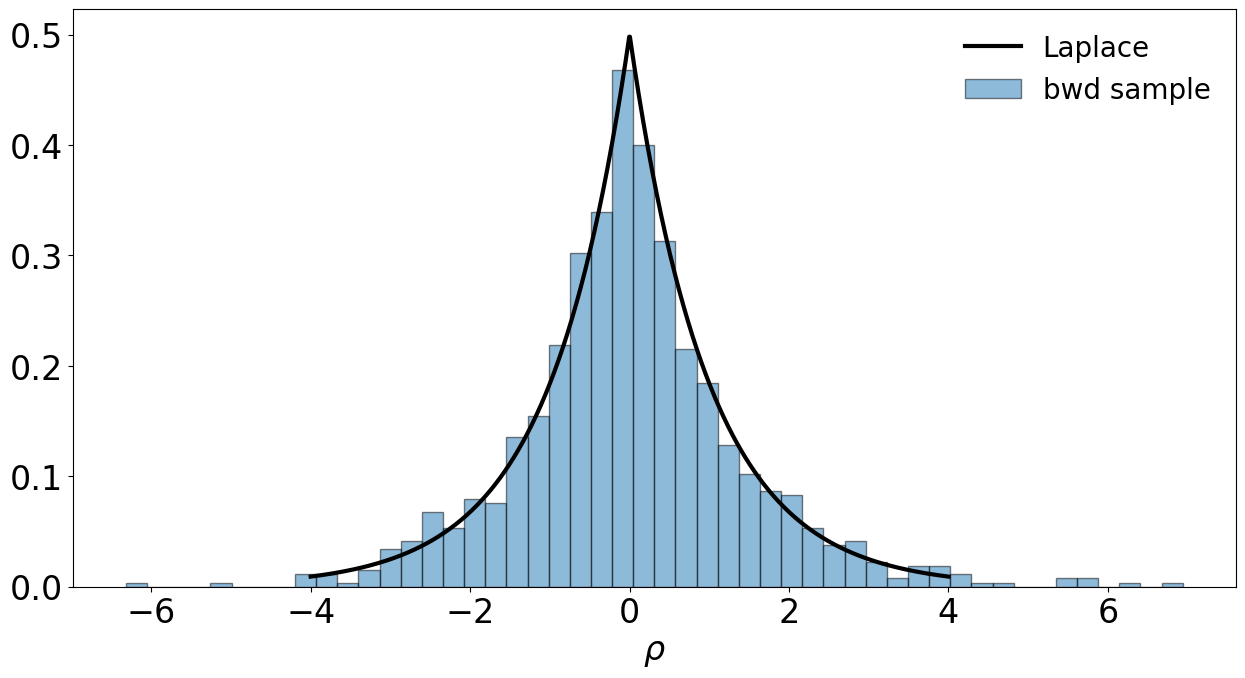

In [150]:
plt.plot(ttrho,np.exp(lap_lm(ttrho[np.newaxis,:])),c='black',lw=3,label='Laplace')
plt.hist(rhopp[0,:],alpha=0.5,density=True,bins=50,ec='black',label='bwd sample');
plt.xlabel(r'$\rho$')
plt.legend(fontsize='small',frameon=False)

Text(0.5, 0, '$u$')

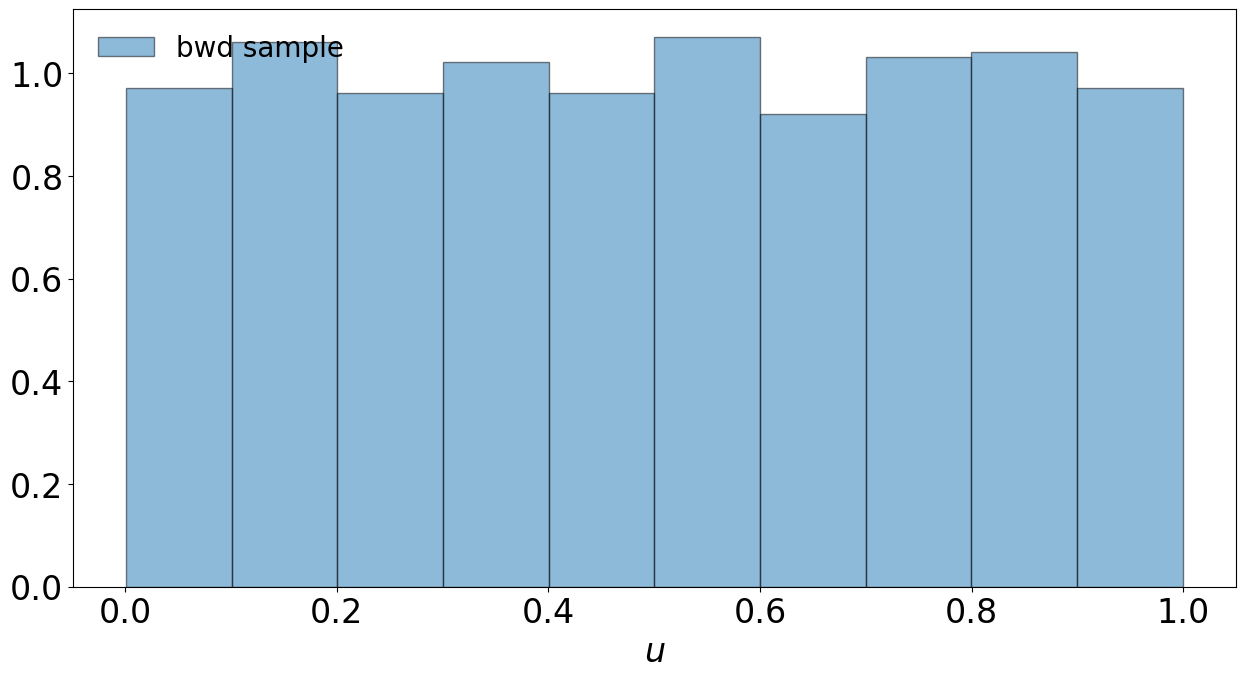

In [151]:
plt.hist(upp,alpha=0.5,density=True,bins=10,ec='black',label='bwd sample');
plt.legend(fontsize='small',frameon=False)
plt.xlabel(r'$u$')

## Stability

Here we show a traceplot of the inverse flow with the (reversed) forward flow
to see if inversion is correct.

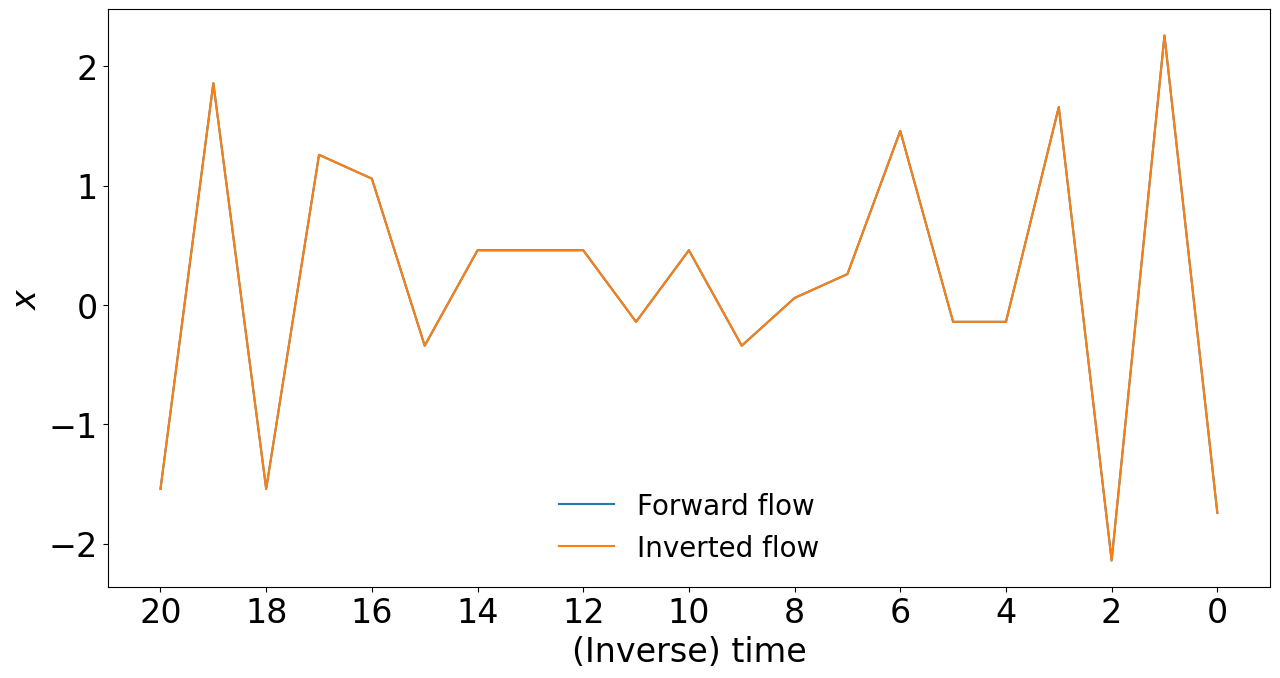

In [152]:
plt.plot(np.arange(0,steps+1),np.flip(xs[:,0,0]),label='Forward flow')
plt.plot(np.arange(0,steps+1),xps[:,0,0],label='Inverted flow')
plt.legend(fontsize='small',frameon=False)
plt.ylabel(r'$x$')
plt.xlabel('(Inverse) time')
plt.xticks(ticks=np.linspace(0,steps,11),
          labels=np.flip(np.linspace(0,steps,11,dtype=int)));

## Sampling

In [153]:
size=10000
sampling_steps=1000
xx,rrho,uu=randqN(size,sampling_steps,randq0,L,epsilon,grad_lp,xi)

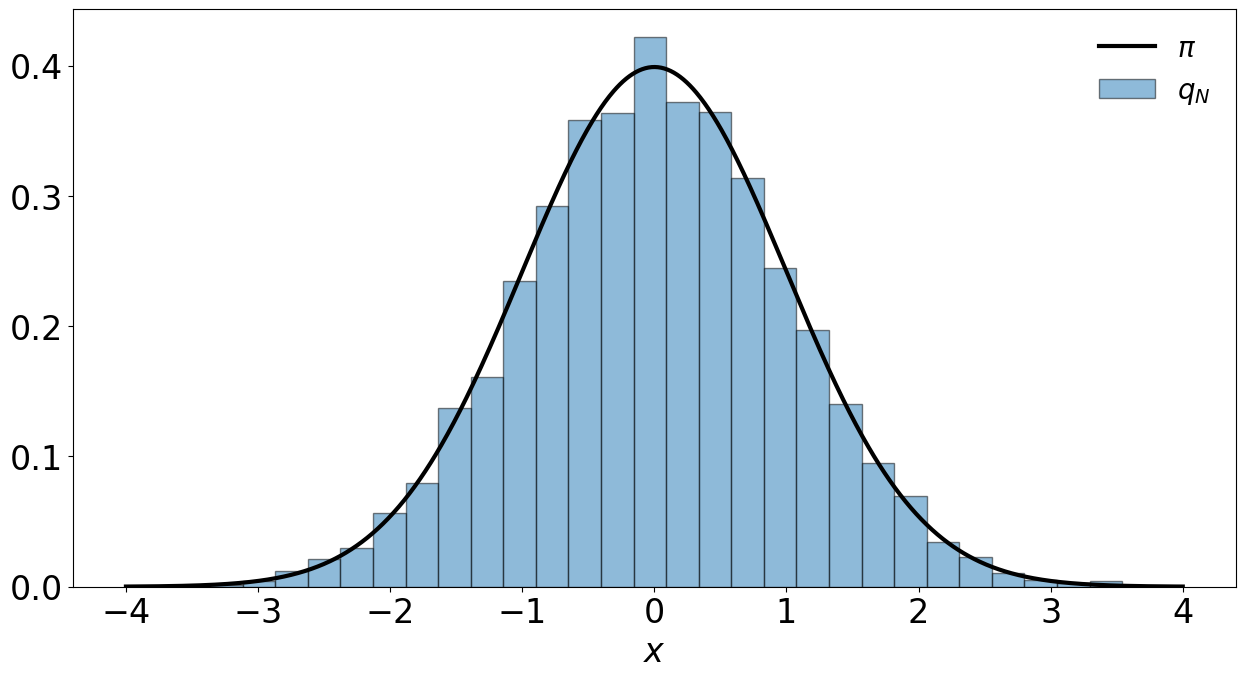

In [154]:
ttxp=np.linspace(-4,4,1000)
plt.plot(ttxp,np.exp(lp(ttxp[np.newaxis,:])),c='black',lw=3,label=r'$\pi$')
plt.hist(xx[0,:],bins=30,density=True,ec='black',alpha=0.5,label=r'$q_N$')
plt.xlabel(r'$x$')
plt.legend(fontsize='small',frameon=False)

## Issue 1: inverting grids instead of pushed samples

In [216]:
new_steps=500
sample_size=1000
initial_x=np.linspace(-4,4,sample_size)[np.newaxis,:]
initial_rho=np.random.laplace(size=1)*np.ones((1,sample_size))
initial_u=np.random.rand()*np.ones(sample_size)
L=50
epsilon=0.1

lq,xs,rhos,us=lqN(initial_x,initial_rho,initial_u,new_steps+1,lq0,L,epsilon,grad_lp,xi)

Flow: 0
x: -4.0
rho: 0.6678774740042251
Gaussian weight: 1.8403161207199448e-87
Laplace weight: 0.25639792300725267
weight: 4.718532310293558e-88

Flow: 1
x: 1.0000000000000024
rho: -7.308768751493235
J: 0.6208621356387611
total J: 0.6208621356387611
Gaussian weight: 0.005140929987637161
Laplace weight: 0.0003348205196154146
weight: 1.0686830713176146e-06
sum weights: 1.0686830713176146e-06

Flow: 2
x: 0.40000000000000246
rho: -0.8798987896668086
J: 0.0010606535949938861
total J: 0.0006585196561608336
Gaussian weight: 8.854339695073437e-07
Laplace weight: 0.20741244706138368
weight: 1.947890606442346e-10
sum weights: 1.0688778603782589e-06

Flow: 3
x: -0.1999999999999976
rho: -0.8911986158143393
J: 0.9524666613011673
total J: 0.000627218018304702
Gaussian weight: 2.793140243396716e-12
Laplace weight: 0.2050819145727246
weight: 5.455943805601536e-13
sum weights: 1.0688784059726394e-06

Flow: 4
x: -0.7999999999999974
rho: 0.2790071641856573
J: 0.7318414025866281
total J: 0.00045902411424

x: -0.7999999999999975
rho: -2.190411707255078
J: 1.5403392743808646
total J: 0.004233351048189508
Gaussian weight: 1.6138061905815658e-19
Laplace weight: 0.055935340581880745
weight: 1.3904457620198355e-20
sum weights: 2.4942801671249297

Flow: 202
x: 2.4000000000000035
rho: 2.582317254899114
J: 18.49075796587646
total J: 0.07827786961666161
Gaussian weight: 0.5467002489199703
Laplace weight: 0.03779930981222797
weight: 0.3821095179041464
sum weights: 2.8763896850290767

Flow: 203
x: -2.5999999999999988
rho: 1.4059925823279324
J: 0.5084824015885384
total J: 0.03980291913391457
Gaussian weight: 1.1750591165195971e-51
Laplace weight: 0.12256181513953959
weight: 7.323030234621703e-53
sum weights: 2.8763896850290767

Flow: 204
x: 1.2000000000000026
rho: -4.375105916972977
J: 1.431755767683701
total J: 0.05698805904063013
Gaussian weight: 0.037986620079325684
Laplace weight: 0.0062934045075596105
weight: 0.0003422829303217026
sum weights: 2.8767319679593983

Flow: 205
x: 1.0000000000000024

x: -0.5999999999999978
rho: -0.019155783230433307
J: 0.28964744784961216
total J: 0.0015307469303956036
Gaussian weight: 6.510558843974187e-17
Laplace weight: 0.4905132614286685
weight: 9.249936004215013e-18
sum weights: 6.8566642280155286

Flow: 394
x: -1.399999999999998
rho: 0.11102185299976625
J: 2.611232582710303
total J: 0.00399713626053278
Gaussian weight: 1.707780634069432e-28
Laplace weight: 0.44745959602322444
weight: 1.9954068870256793e-28
sum weights: 6.8566642280155286

Flow: 395
x: -0.5999999999999976
rho: 0.9982852268403714
J: 0.9808781080980183
total J: 0.003920703453041381
Gaussian weight: 6.510558843974187e-17
Laplace weight: 0.18425540606871302
weight: 1.1766669337076802e-17
sum weights: 6.8566642280155286

Flow: 396
x: -0.9999999999999977
rho: -0.10269758020434733
J: 0.5649699093482049
total J: 0.0022150794744459825
Gaussian weight: 2.5648662089023003e-22
Laplace weight: 0.45119991789694613
weight: 6.538212709924013e-23
sum weights: 6.8566642280155286

Flow: 397
x: -

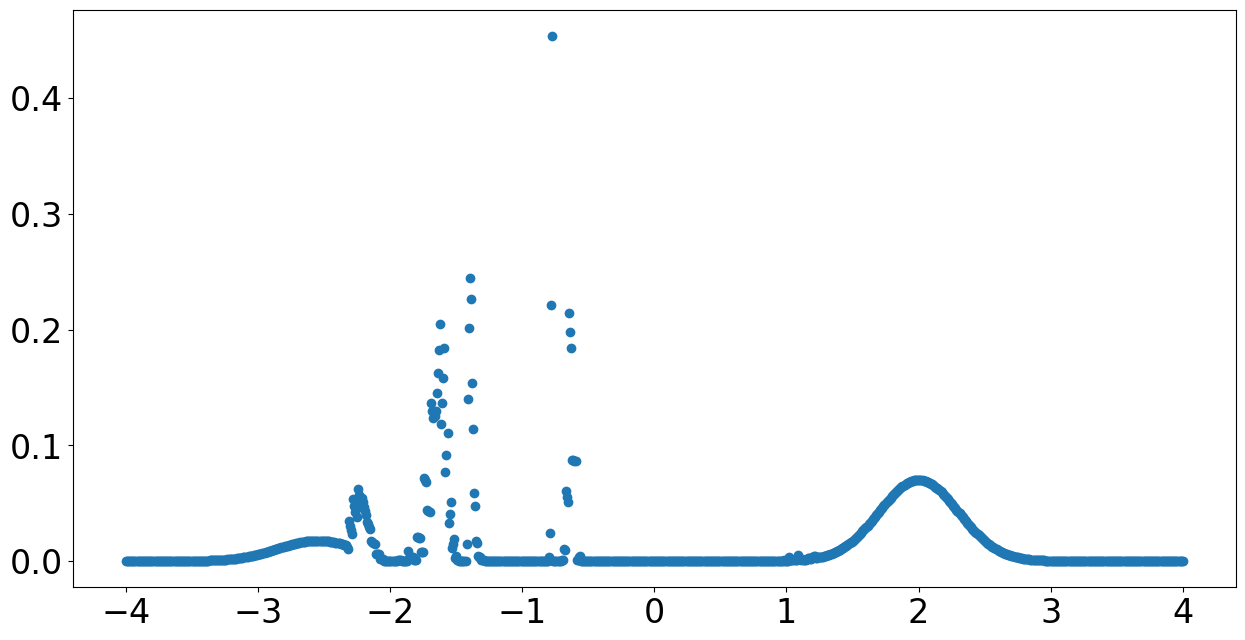

In [211]:
plt.scatter(initial_x,np.exp(lq))

(array([  5.,  17.,  66., 156., 224., 238., 158.,  95.,  34.,   7.]),
 array([-3.37857858, -2.73665666, -2.09473473, -1.45281281, -0.81089089,
        -0.16896897,  0.47295295,  1.11487487,  1.7567968 ,  2.39871872,
         3.04064064]),
 <BarContainer object of 10 artists>)

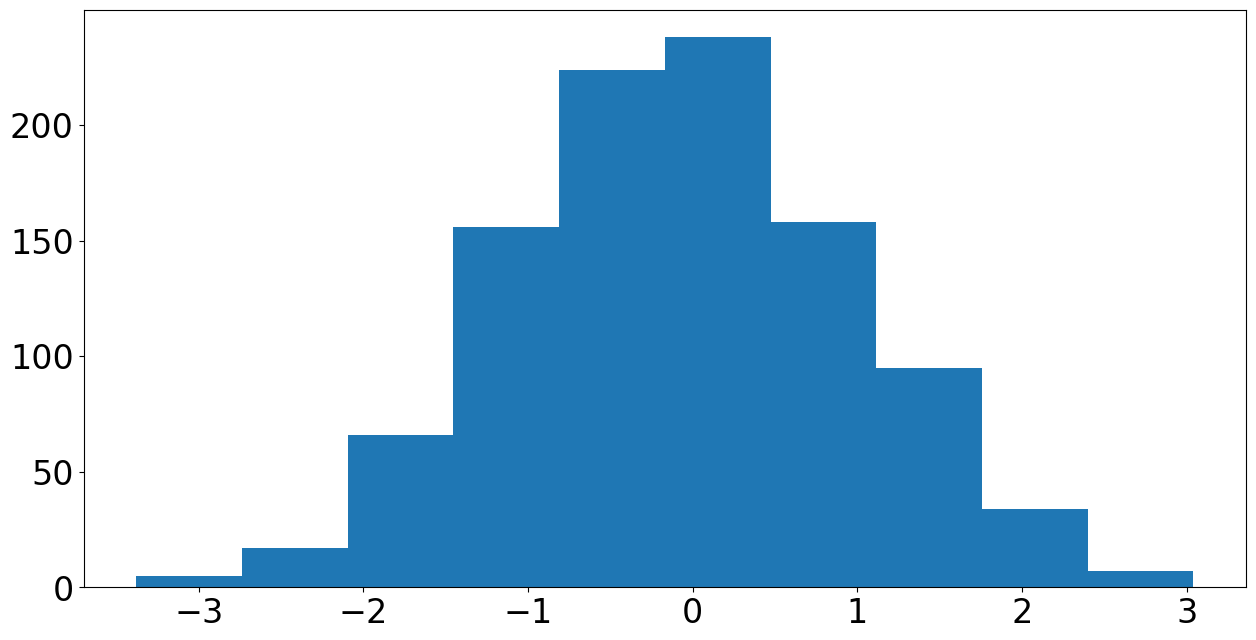

In [220]:
plt.hist(xs[-1,0,:])

In [213]:
rhos=np.linspace(-4,4,100)
lqs=np.zeros((rhos.shape[0],1000))
for i in range(rhos.shape[0]):
    tmp_lq,_,_,_=lqN(initial_x,rhos[i]*np.ones((1,sample_size)),initial_u,new_steps+1,lq0,L,epsilon,grad_lp,xi)
    lqs[i,:]=np.exp(tmp_lq)

Flow: 0
x: -4.0
rho: -4.0
Gaussian weight: 1.8403161207199448e-87
Laplace weight: 0.00915781944436709
weight: 1.685328275411129e-89

Flow: 1
x: 2.858824288409778e-15
rho: -9.904883693512986
J: 0.19111428224367916
total J: 0.19111428224367916
Gaussian weight: 2.9703000624509136e-10
Laplace weight: 2.496512082936381e-05
weight: 1.4171869366148584e-15
sum weights: 1.4171869366148584e-15

Flow: 0
x: -4.0
rho: -3.919191919191919
Gaussian weight: 1.8403161207199448e-87
Laplace weight: 0.009928567216026803
weight: 1.827170230330567e-89

Flow: 1
x: -0.19999999999999715
rho: -10.778668216353077
J: 0.21058621536221736
total J: 0.21058621536221736
Gaussian weight: 2.7931402433967356e-12
Laplace weight: 1.0419667864938713e-05
weight: 6.128815637326892e-18
sum weights: 6.128815637326892e-18

Flow: 0
x: -4.0
rho: -3.8383838383838382
Gaussian weight: 1.8403161207199448e-87
Laplace weight: 0.010764183282058026
weight: 1.9809500020355562e-89

Flow: 1
x: -0.19999999999999715
rho: -10.760785747272633
J: 

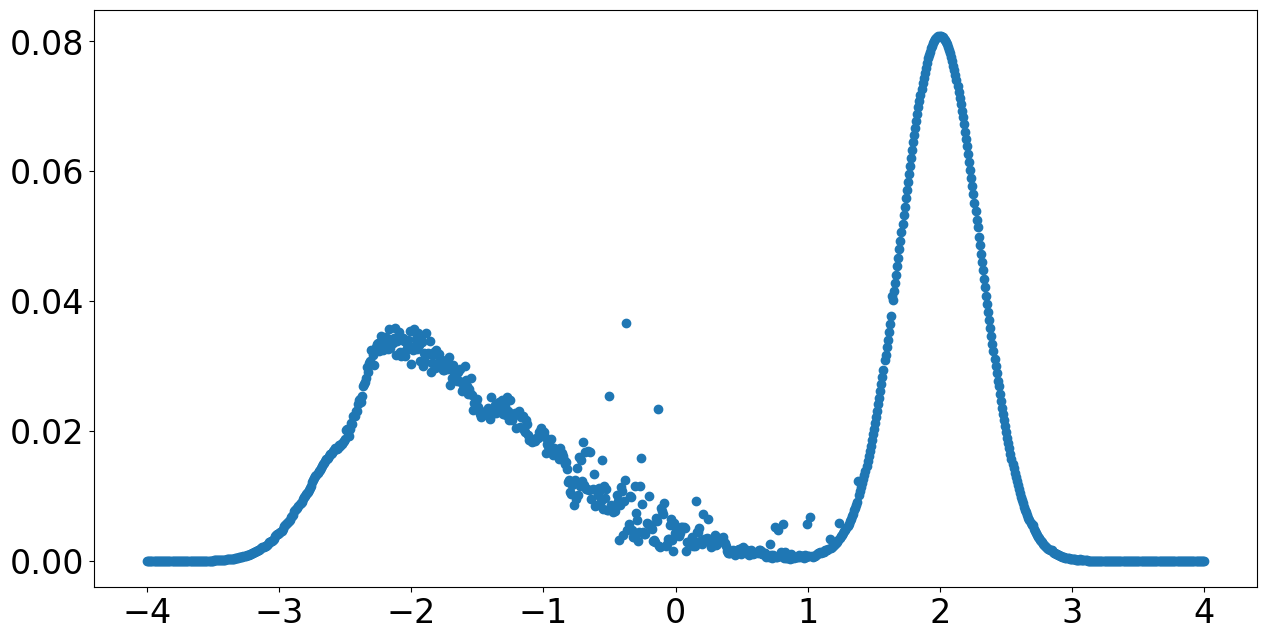

In [214]:
plt.scatter(initial_x[0,:],np.mean(lqs,axis=0))

Text(0.5, 1.0, 'Traceplot')

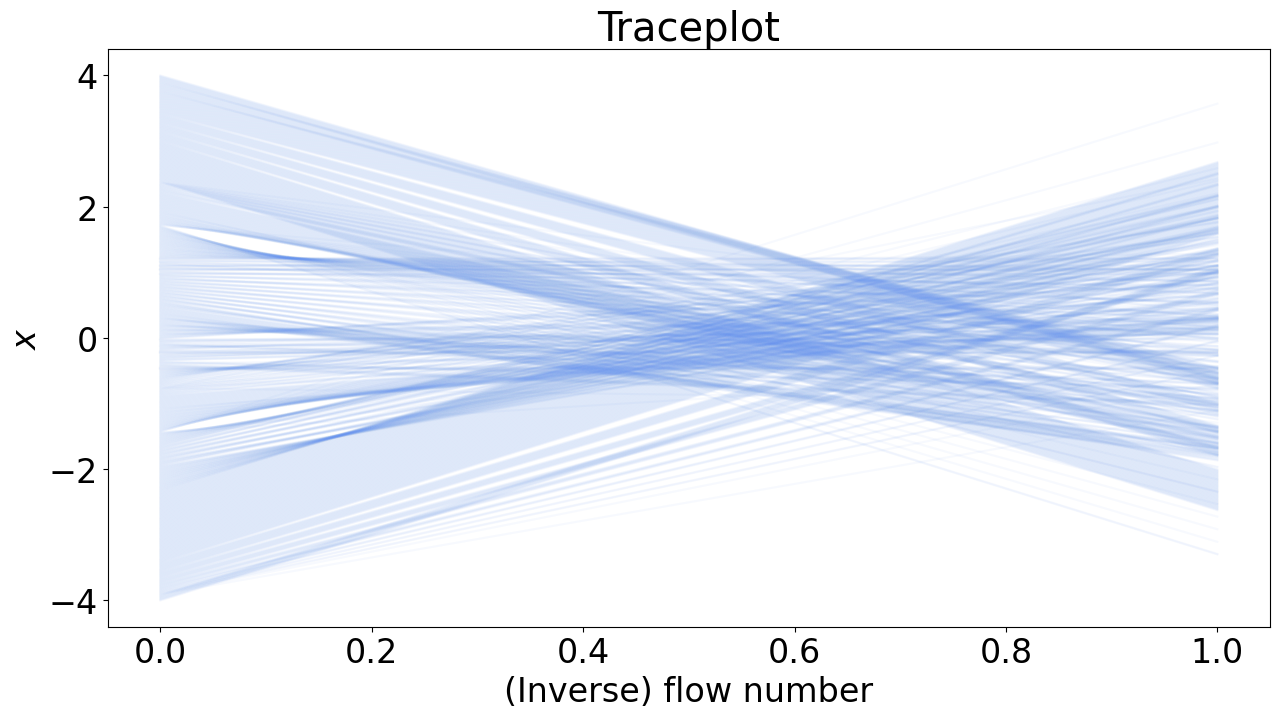

In [212]:
for n in range(xs.shape[-1]): plt.plot(np.arange(0,xs.shape[0]),xs[:,0,n],c='cornflowerblue',alpha=0.05)
plt.xlabel('(Inverse) flow number')
plt.ylabel(r'$x$')
plt.title('Traceplot')

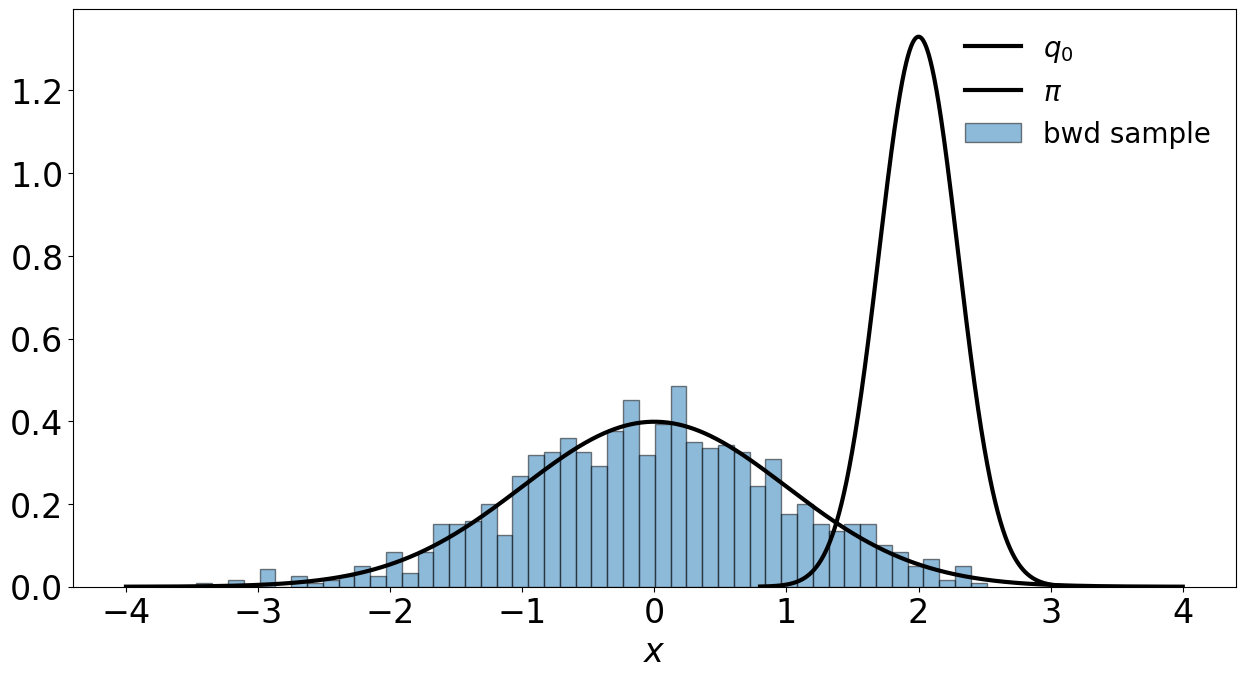

In [89]:
ttx=np.linspace(mu0-4*sigma0,mu0+4*sigma0,1000)
plt.plot(ttx,np.exp(gauss_lp(ttx[np.newaxis,:],mu0,sigma0)),c='black',lw=3,label=r'$q_0$')
ttxp=np.linspace(-4,4,1000)
plt.plot(ttxp,np.exp(lp(ttxp[np.newaxis,:])),c='black',lw=3,label=r'$\pi$')
plt.hist(final_x[0,:],alpha=0.5,density=True,bins=50,ec='black',label='bwd sample');
plt.xlabel(r'$x$')
plt.legend(fontsize='small',frameon=False)

## Issue 2: density

In [127]:
lq,xs,rhos,us=lqN(xp,rhop,up,steps+1,lq0,L,epsilon,grad_lp,xi)

Flow: 1
x: 1.609477756976012
rho: -1.3099068322069733
J: 0.08781741099614863
total J: 0.08781741099614863
Gaussian weight: 0.5699365174831401
Laplace weight: 0.134922598047471
weight: 0.0067529231738985
sum weights: 0.0067529231738985

Flow: 2
x: -0.39052224302398864
rho: -1.7050786748425693
J: 0.443803096205485
total J: 0.03897363890084037
Gaussian weight: 2.167266541675689e-14
Laplace weight: 0.09087904291202402
weight: 8.741106241904111e-16
sum weights: 0.006752923173899374

Flow: 3
x: 0.20947775697601137
rho: -0.09142019152355471
J: 0.2051758933790706
total J: 0.007996451179713223
Gaussian weight: 2.4467756849108098e-08
Laplace weight: 0.45631707459331217
weight: 2.290800180876755e-09
sum weights: 0.006752925464699555

Flow: 4
x: 0.009477756976011414
rho: 0.10280696132682501
J: 0.9455372305583524
total J: 0.007560942302761112
Gaussian weight: 3.6648256286791246e-10
Laplace weight: 0.45115056784249613
weight: 1.5633400650803018e-10
sum weights: 0.006752925621033561

Flow: 5
x: 0.409

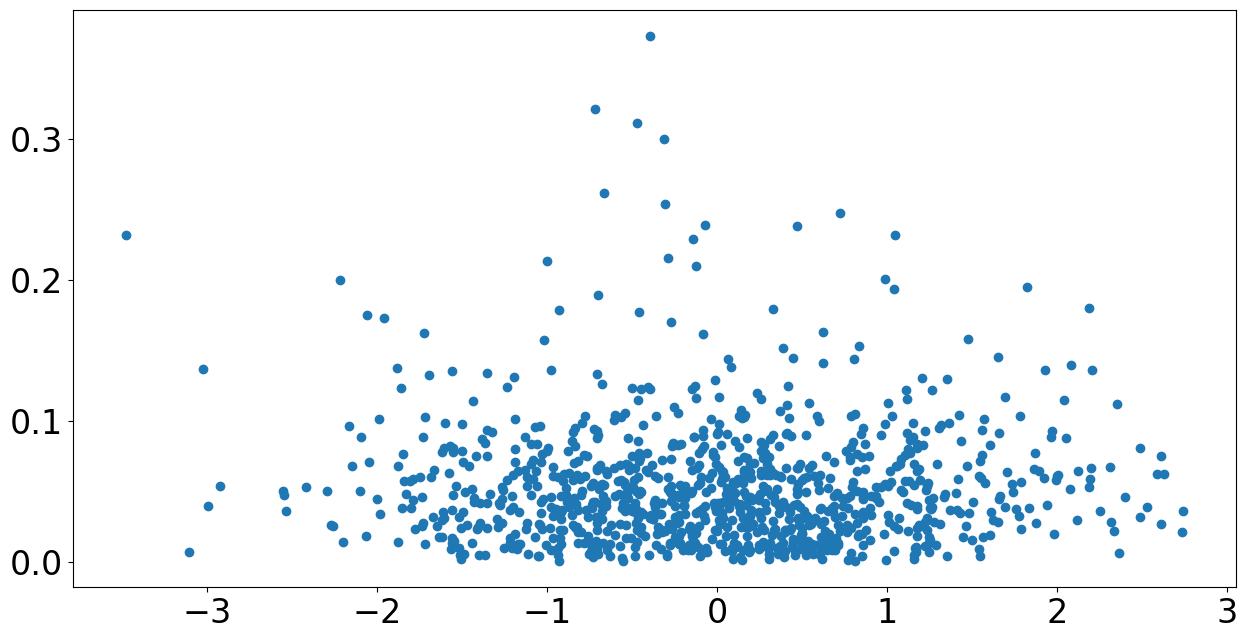

In [128]:
plt.scatter(xp,np.exp(lq))

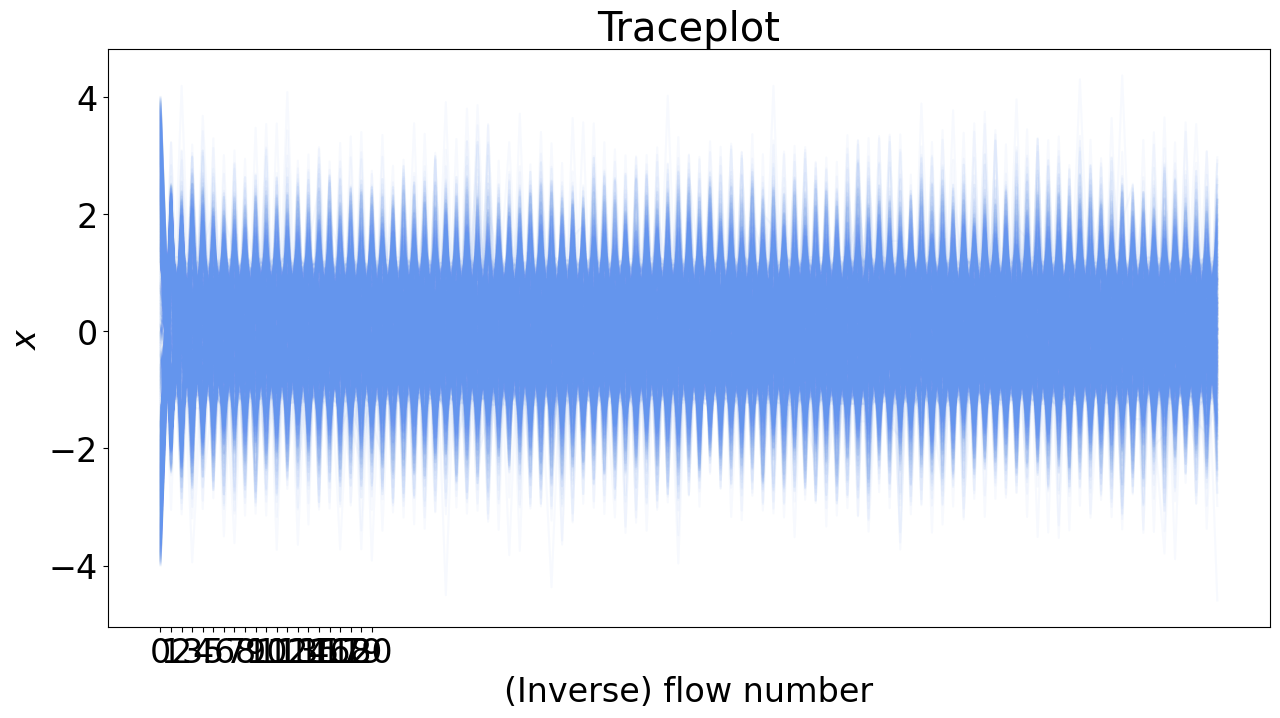

In [131]:
for n in range(xs.shape[-1]): plt.plot(np.arange(0,xs.shape[0]),xs[:,0,n],c='cornflowerblue',alpha=0.05)
plt.xlabel('(Inverse) flow number')
plt.ylabel(r'$x$')
plt.title('Traceplot')
plt.xticks(ticks=np.arange(0,steps+1));